In [1]:
import copy
import itertools
import pandas as pd
import numpy as np

import bpmn_python.bpmn_diagram_layouter as layouter
import bpmn_python.bpmn_diagram_visualizer as visualizer
import bpmn_python.bpmn_diagram_rep as diagram

In [15]:
#logs = pd.read_csv('logs_XOR.csv')
logs = pd.read_csv('logs.csv')
num_cases = len(logs.case_id.unique())
cases = []
num_cases
for num in range (num_cases):
    cases.append((list((logs.loc[logs['case_id'] == num+1]).task)))

cases

[['a', 'b', 'c', 'd'],
 ['a', 'c', 'b', 'd'],
 ['a', 'b', 'c', 'd'],
 ['a', 'c', 'b', 'd'],
 ['e', 'f', 'h'],
 ['e', 'g', 'h']]

In [16]:
tasks_dict = {}
tasks = logs.task.unique()

for num, task in enumerate(tasks, start=1):
    tasks_dict[task] = num
tasks_dict


{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8}

In [17]:
T_0 = list(logs.task.unique())
T_1 = []
T_n = []
for case in cases:
    T_1.append(case[0])
    T_n.append(case[-1])
T_1=list(set(T_1))
T_n=list(set(T_n))


In [18]:
#rel_dict = {0: '#', 1: '->', -1: '<-', 2: '||'}
relations = np.zeros((len(T_0),len(T_0)), dtype = int)

for case in cases:
    for num, task in enumerate(case[:-1]):
        this_task = T_0.index(case[num])
        next_task = T_0.index(case[num+1])        
        relations[this_task, next_task] = 1 

for (x,y), value in np.ndenumerate(relations):
    if np.all(relations[x,y] == relations[y,x]== 1):
        relations[x,y] = 2
        relations[y,x] = 2
    elif relations[x,y] == 1:
        relations[y,x] = -1
    
relations    

array([[ 0,  1,  1,  0,  0,  0,  0,  0],
       [-1,  0,  2,  1,  0,  0,  0,  0],
       [-1,  2,  0,  1,  0,  0,  0,  0],
       [ 0, -1, -1,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  1,  1,  0],
       [ 0,  0,  0,  0, -1,  0,  0,  1],
       [ 0,  0,  0,  0, -1,  0,  0,  1],
       [ 0,  0,  0,  0,  0, -1, -1,  0]])

In [19]:
def nextZeroIndex(array, start):
    nextItems = array[start+1:]
    for i, x in enumerate(nextItems):
        if x != 0:
            return 1 + start + i

In [20]:
Xl_a = []
Xl_b = []
Xl_c = []
P_d = []
P_e = []

for task in range(len(T_0)):
    
    x = task
    y = nextZeroIndex(relations[x],0)
    if not y :
        continue 
    
    for i in range (len(T_0)-y):
        a = y+i
        if relations[x,a] == 1 and relations[a,x] == -1: 
            Xl_a.append((T_0[x],T_0[a])) #A is ok
        
    for i in range (len(T_0)-y):
        a = y+i
        z = nextZeroIndex(relations[x],a)
        if not (a and z):
            continue  
        
        if np.all(relations[x,a] == 1 and relations[x,z] == 1 and relations[a,z] == 0):
            Xl_b.append((T_0[x],(T_0[a],T_0[z]))) 
        if np.all(relations[x,a] == -1 and relations[x,z] == -1 and relations[a,z] == 0):
            Xl_c.append(((T_0[a],T_0[z]),T_0[x])) #C is ok
            
        if np.all(relations[x,a] == 1 and relations[x,z] == 1 and relations[a,z] == 2):
            P_d.append((T_0[x],(T_0[a], T_0[z]))) #k
        if np.all(relations[x,a] == -1 and relations[x,z] == -1 and relations[a,z] == 2):
            P_e.append(((T_0[a], T_0[z]),T_0[x])) 

In [21]:
Yl = copy.deepcopy(Xl_a)

for bit in Xl_b:    
    Yl.remove((bit[0], bit[1][0]))
    Yl.remove((bit[0], bit[1][1]))
    #Yl.append(bit)

for bit in Xl_c:    
    Yl.remove((bit[0][0], bit[1]))
    Yl.remove((bit[0][1], bit[1]))
    #Yl.append(bit)

for bit in P_d:    
    Yl.remove((bit[0], bit[1][0]))
    Yl.remove((bit[0], bit[1][1]))
    #Yl.append(bit)

for bit in P_e:    
    Yl.remove((bit[0][0], bit[1]))
    Yl.remove((bit[0][1], bit[1]))
    #Yl.append(bit)
    
Yl

[]

In [22]:
bpmn_graph = diagram.BpmnDiagramGraph()
bpmn_graph.create_new_diagram_graph(diagram_name="diagram1")
process_id = bpmn_graph.add_process_to_diagram()
output_png_file = "diagram"
output_file_with_di = "output.xml"
output_directory = "./"

In [23]:
[start_id,_] = bpmn_graph.add_start_event_to_diagram(process_id, start_event_name="start_event", )

xors_fork = []
for n in Xl_b:
    xors_fork.append((bpmn_graph.add_exclusive_gateway_to_diagram(process_id, gateway_name="exclusive_gate_fork"))[0])

ands_fork = []
for t in P_d:
    ands_fork.append((bpmn_graph.add_parallel_gateway_to_diagram(process_id, gateway_name="parallel_gate_fork"))[0])

all_tasks = []
for task in tasks: 
    all_tasks.append((bpmn_graph.add_task_to_diagram(process_id, task_name=str(task)))[0])
    #print(all_tasks)


xors_join = []
for i in Xl_c:
    xors_join.append((bpmn_graph.add_exclusive_gateway_to_diagram(process_id, gateway_name="exclusive_gate_join"))[0])

ands_join = []                     
for k in P_e:
    ands_join.append((bpmn_graph.add_parallel_gateway_to_diagram(process_id, gateway_name="parallel_gate_join"))[0])

[end_id, _] = bpmn_graph.add_end_event_to_diagram(process_id, end_event_name="end_event", )



In [24]:
if len(T_1)>1:
    [first_xor,_] = bpmn_graph.add_exclusive_gateway_to_diagram(process_id, gateway_name="exclusive_gate_fork")
    #start_id -> XOR
    bpmn_graph.add_sequence_flow_to_diagram(process_id, source_ref_id=start_id, target_ref_id=first_xor)
    for elem in T_1:
        bpmn_graph.add_sequence_flow_to_diagram(process_id, source_ref_id=first_xor, target_ref_id=all_tasks[T_0.index(elem)] )
        #XOR -> bit
else:
    bpmn_graph.add_sequence_flow_to_diagram(process_id, source_ref_id=start_id, target_ref_id=all_tasks[T_0.index(T_1[0])]) #start_event -> T_1[0]

for bits in T_n:
    bpmn_graph.add_sequence_flow_to_diagram(process_id, source_ref_id=all_tasks[T_0.index(bits)], target_ref_id=end_id )#bit -> end_event
    
for A in Yl:
    bpmn_graph.add_sequence_flow_to_diagram(process_id, source_ref_id=all_tasks[T_0.index(A[0])], target_ref_id=all_tasks[T_0.index(A[1])] )#A[0] -> A[1]
    
for num, B in enumerate(Xl_b):
    bpmn_graph.add_sequence_flow_to_diagram(process_id, source_ref_id=all_tasks[T_0.index(B[0])], target_ref_id=xors_fork[num] )#B[0] -> XOR 
    bpmn_graph.add_sequence_flow_to_diagram(process_id, source_ref_id=xors_fork[num], target_ref_id=all_tasks[T_0.index(B[1][0])] )#XOR -> B[1][0]
    bpmn_graph.add_sequence_flow_to_diagram(process_id, source_ref_id=xors_fork[num], target_ref_id=all_tasks[T_0.index(B[1][1])] )#XOR -> B[1][1]
    
for num, C in enumerate(Xl_c):
    bpmn_graph.add_sequence_flow_to_diagram(process_id, source_ref_id=all_tasks[T_0.index(C[0][0])], target_ref_id=xors_join[num] )#C[0][0] -> XOR
    bpmn_graph.add_sequence_flow_to_diagram(process_id, source_ref_id=all_tasks[T_0.index(C[0][1])], target_ref_id=xors_join[num] )#C[0][1] -> XOR
    bpmn_graph.add_sequence_flow_to_diagram(process_id, source_ref_id=xors_join[num], target_ref_id=all_tasks[T_0.index(C[1])] )#XOR -> C[1]
    
for num, D in enumerate(P_d):
    bpmn_graph.add_sequence_flow_to_diagram(process_id, source_ref_id=all_tasks[T_0.index(D[0])], target_ref_id=ands_fork[num] )#D[0] -> AND 
    bpmn_graph.add_sequence_flow_to_diagram(process_id, source_ref_id=ands_fork[num], target_ref_id=all_tasks[T_0.index(D[1][0])] )#AND -> D[1][0]
    bpmn_graph.add_sequence_flow_to_diagram(process_id, source_ref_id=ands_fork[num], target_ref_id=all_tasks[T_0.index(D[1][1])] )#AND -> D[1][1]
    
for num, E in enumerate(P_e):
    bpmn_graph.add_sequence_flow_to_diagram(process_id, source_ref_id=all_tasks[T_0.index(E[0][0])], target_ref_id=ands_join[num] )#E[0][0] -> AND
    bpmn_graph.add_sequence_flow_to_diagram(process_id, source_ref_id=all_tasks[T_0.index(E[0][1])], target_ref_id=ands_join[num] )#E[0][1] -> AND
    bpmn_graph.add_sequence_flow_to_diagram(process_id, source_ref_id=ands_join[num], target_ref_id=all_tasks[T_0.index(E[1])] )#AND -> E[1]        

    
#g.graph_attr['rankdir'] = 'LR'

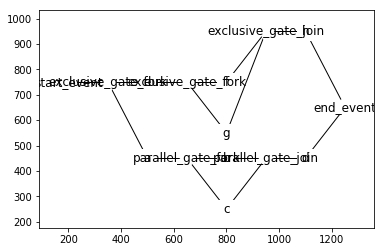

In [25]:
layouter.generate_layout(bpmn_graph)
#bpmn_python.bpmn_diagram_layouter.insert_into_grid(grid, 8, col, node_id)
bpmn_graph.export_xml_file(output_directory, output_file_with_di)
visualizer.bpmn_diagram_to_png(bpmn_graph, output_directory + output_png_file)
visualizer.visualize_diagram(bpmn_graph)